### Extracting data from DNAMO Zip File

In [ ]:
import tarfile
my_tar = tarfile.open('F:/D1NAMO.tgz')
my_tar.extractall('F:/my_folder') # specify which folder to extract to
my_tar.close()


### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from time import time
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import re
import fnmatch

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
signals = ['glucose','Breathing','ECG','Accel','Summary']
dataset_path='F:/btp_working_directory'

### Extract data from each patient

In [3]:
def Patient_Data(Patient_number):   
    
    import warnings
    warnings.filterwarnings("ignore")

    def Summary_readings():    
 
        summary = pd.DataFrame()

        for i in [1,2,3,4,5,6,7,8,9]:
            files = glob.glob('F:/btp_working_directory/D1NAMO/**/*.csv',recursive=True)
            x = os.path.join('*dia**/'+'00'+str(i)+'/sensor_data/'+'*'+signals[-1]+'.csv')
            path= [file for file in files if fnmatch.fnmatch(file,x)]

            #read all glucose files for all diabetic subjects
            summ_patient = pd.concat([pd.read_csv(file) for file in path],axis=0)
            summ_patient['patient']=i
            summary = summary.append(summ_patient)

        ## convert the time column to be the index

        summary['Time'] = pd.to_datetime(summary['Time'],format='%d/%m/%Y %H:%M:%S.%f')
        summary['Time'] = summary['Time'].astype('datetime64[s]')
        summary = summary.set_index(summary['Time'])
        summary.drop(columns =['Time'],inplace=True)

        return summary
    
    summary = Summary_readings()    
    summary_patient = summary[summary.patient==Patient_number]
    
    files = glob.glob('F:/btp_working_directory/D1NAMO/**/*.csv',recursive=True)
    x = os.path.join('*dia**/'+'**/'+'glucose'+'.csv')

    #read all glucose files for all diabetic subjects
    glucoses = [pd.read_csv(file).drop(['type','comments'],axis=1) for file in files if fnmatch.fnmatch(file,x)]


    #Identify patient by adding a column with subject number staring from 1 to 9
    for i,glu in enumerate(glucoses):
        glu['patient'] = np.ones(glu.shape[0])*(i+1) 

    # glucoses: adding differntiation column
    for glu in glucoses:
        glu['glucose_diff'] = glu.glucose.diff()

    glucose = pd.concat(glucoses,axis = 0 )
    glucose['time'] = glucose.pipe(lambda x : pd.to_datetime(x['date']+' '+x['time']))    
    glucose.drop(columns=['date'],inplace=True)
    glucose['bin_number']= glucose.index
    glucose.index = glucose['time']
    glucose.drop(columns=['time'],inplace=True)
    
    try:
        glucose_patient = glucose.iloc[glucose.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')
    
    except:
        x=glucose[glucose['patient']==Patient_number]
        x1=x[x.index.value_counts()>1].reset_index().drop_duplicates(subset='time', keep='first')
        x1.set_index('time',inplace=True)
        x2=x[x.index.value_counts()<2]
        x3=pd.concat([x2,x1],axis=0,sort=True)
        x3.sort_index(inplace=True)
        glucose_patient = x3.iloc[x3.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')

    the_join= glucose_patient.join(summary_patient,lsuffix='g',rsuffix='s',how='inner')
    
    return the_join


In [4]:
for i in [1,2,4,5,6,7,8,9]:
    if(i == 1):
        x = Patient_Data(i).reset_index(drop=True)
    else:    
        x = pd.concat([x,Patient_Data(i).reset_index(drop=True)],axis=0,ignore_index=True)

### Filter out inconsistent data

In [5]:
xx = x.drop(["bin_number", "patientg", "BR","SkinTemp", "Posture", "Activity", "PeakAccel", "BatteryVolts","BatteryLevel", "BRAmplitude", "BRNoise", "BRConfidence","SystemConfidence","GSR", "ROGState", "ROGTime", "VerticalMin", "VerticalPeak","LateralMin", "LateralPeak", "SagittalMin", "SagittalPeak","DeviceTemp", "StatusInfo", "LinkQuality", "RSSI", "TxPower","CoreTemp", "AuxADC1", "AuxADC2", "AuxADC3", "patients"],axis=1)
pp_data = xx[xx['HR']>45]
pp_data = pp_data[pp_data['glucose_diff'].notnull()]
pp_data = pp_data.drop("glucose_diff",axis=1)
p=pp_data

### Correlation

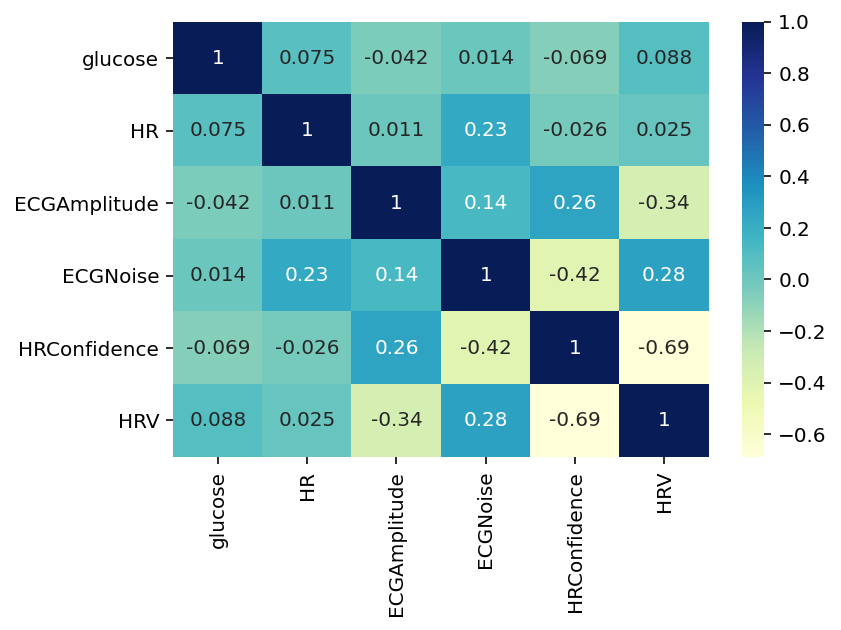

In [6]:
p.corr()
import seaborn
plot = seaborn.heatmap(p.corr(),cmap="YlGnBu", annot=True)

### Creating Labels for Normal and Diabetic Classes 

In [ ]:
dummies=pd.get_dummies(pd.cut(p.glucose,[1,7.00,25],labels=['Normal','Diabetic']))
glucose = pp_data['glucose']
glucose_labels = glucose.copy()
for j in glucose.index:
    if dummies['Normal'][j] == 1:
        glucose_labels[j] = 0
    elif dummies['Diabetic'][j] == 1:
        glucose_labels[j] = 1


pp_data = pp_data.drop('glucose',axis=1)


### Test-Train Split and saving data as numpy files

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pp_data, glucose_labels, test_size=0.2, random_state=42)
np.save("F:/btp_working_directory/binary/X_train",X_train)
np.save("F:/btp_working_directory/binary/X_test",X_test)
np.save("F:/btp_working_directory/binary/y_train",y_train)
np.save("F:/btp_working_directory/binary/y_test",y_test)

###  Creating Labels for Low,Normal and High Classes 

In [ ]:
dummies=pd.get_dummies(pd.cut(p.glucose,[0,4.95,7.77,25],labels=['L','N','H']))
glucose = pp_data['glucose']
glucose_labels = glucose.copy()
for j in glucose.index:
    if dummies['L'][j] == 1:
        glucose_labels[j] = 0
    elif dummies['N'][j] == 1:
        glucose_labels[j] = 1
    elif dummies['H'][j] == 1:
        glucose_labels[j] = 2

pp_data = pp_data.drop('glucose',axis=1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pp_data, glucose_labels, test_size=0.2, random_state=42)
np.save("F:/btp_working directory/Ready_data/X_train.np",X_train)
np.save("F:/btp_working directory/Ready_data/X_test.np",X_test)
np.save("F:/btp_working directory/Ready_data/y_train.np",y_train)
np.save("F:/btp_working directory/Ready_data/y_test.np",y_test)